# Setting Workspace

In [1]:
!pip install ipython-autotime
!pip install transformers

     |████████████████████████████████| 2.6 MB 5.0 MB/s 
     |████████████████████████████████| 636 kB 37.9 MB/s 
     |████████████████████████████████| 895 kB 41.4 MB/s 
     |████████████████████████████████| 3.3 MB 39.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
%load_ext autotime

time: 157 µs (started: 2021-08-08 09:58:24 +00:00)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 16.2 s (started: 2021-08-08 09:58:24 +00:00)


In [4]:
import os
os.chdir('/content/drive/My Drive/HLT/')
!pwd

/content/drive/My Drive/HLT
time: 125 ms (started: 2021-08-08 09:58:40 +00:00)


# Import Libraries

In [5]:
import json
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import Dropout
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.layers import LSTM, Dense,Flatten,Conv2D,Conv1D,GlobalMaxPooling1D,GlobalMaxPool1D
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve
import seaborn as sns
from tensorflow.keras.optimizers import Adam

time: 3.25 s (started: 2021-08-08 09:58:41 +00:00)


In [6]:
pd.set_option('display.max_colwidth', -1) #show all text in col
pd.set_option('display.max_rows', None) #show all rows

time: 3.09 ms (started: 2021-08-08 09:58:44 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


# Support Functions


In [7]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

time: 73.7 ms (started: 2021-08-08 09:58:44 +00:00)


# Load the Dataset

In [8]:
train_df = pd.read_csv("datasets/train.csv") 
train_df['headline']=train_df['headline'].apply(str)
train_df.head()

,headline,is_sarcastic
0,bill de blasio thinks proved haters wrong comes pre k,0
1,baby realize white supremacist yet,1
2,spring sprung arctic way early,0
3,mayor daley son appointed head illinois nepotist party,1
4,poll grandsons talented,1


time: 217 ms (started: 2021-08-08 09:58:44 +00:00)


In [9]:
test_df = pd.read_csv("datasets/test.csv") 
test_df['headline']=test_df['headline'].apply(str)
test_df.head()

,headline,is_sarcastic
0,jessie james decker shares inspiring message post baby bodies,0
1,frustrated russian officials struggling get policies dysfunctional trump administration,1
2,second saturday staten island art walk,0
3,chris christie emits loud sob paul ryan asks crowd whether worse years ago,1
4,chicago police department monitor interactions public using new bullet cams,1


time: 157 ms (started: 2021-08-08 09:58:44 +00:00)


In [10]:
print("Train size:{}".format(train_df.shape))
print("Test size:{}".format(test_df.shape))

Train size:(22702, 2)
Test size:(4007, 2)
time: 3.26 ms (started: 2021-08-08 09:58:44 +00:00)


## Splitting the set



In [11]:
train_y = train_df['is_sarcastic']
test_y = test_df['is_sarcastic']

train_x = train_df['headline']
test_x = test_df['headline']
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((22702,), (22702,), (4007,), (4007,))

time: 9.36 ms (started: 2021-08-08 09:58:44 +00:00)


## Glove


In [12]:
txt_best_grids = "grid_results/bidirectional_lstm/best_results_lstm_glove_v1.txt" # name of the txt file with all best results of all runned grid searches
grid_results_name = 'grid_results/bidirectional_lstm/grid_results_lstm_glove_v1.csv' # name of the csv file with all tests of the current grid search

time: 2.88 ms (started: 2021-08-08 09:58:44 +00:00)


In [13]:
##Build Static Embedding on top of a LSTM
maxlen=26
max_features=200 
embed_size=300
 

#Tokenizing steps- must be remembered
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_x))

train_x=tokenizer.texts_to_sequences(train_x)
test_x=tokenizer.texts_to_sequences(test_x)

#Pad the sequence- To allow same length for all vectorized words
train_x=pad_sequences(train_x,maxlen=maxlen)
test_x=pad_sequences(test_x,maxlen=maxlen)



EMBEDDING_FILE = 'Embeddings/glove.6B.200d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8") if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


time: 27.1 s (started: 2021-08-08 09:58:44 +00:00)


### Adam

In [14]:
# inp=Input(shape=(maxlen,))
# z=Embedding(max_features,embed_size,weights=[embedding_matrix])(inp)
# z=Bidirectional(LSTM(60,return_sequences='True'))(z)
# z=GlobalMaxPool1D()(z)
# z=Dense(16,activation='relu')(z)
# z=Dense(1,activation='sigmoid')(z)
# model=Model(inputs=inp,outputs=z)
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()
# plot_model(
#     model,
#     to_file="glove_simple_model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
# )

# model.fit(train_x,train_y,batch_size=128,epochs=2,verbose=2, validation_split=0.1)#validation_data=(val_x,val_y))

time: 3.9 ms (started: 2021-08-08 09:59:11 +00:00)


In [15]:
# Function to create model, required for KerasClassifier
def create_model(neurons_layer_1=60,
                 activation='relu',
                 neurons_layer_2 = 16,
                 dropout_1 = 0.5, dropout_2 = 0.2,
                 neurons_layer_3 = 20, learn_rate = 0.1):
  # create model
    model = Sequential()
    model.add(Embedding(max_features,embed_size,input_length=maxlen, weights=[embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(neurons_layer_1,activation=activation, return_sequences='True')))
    model.add(GlobalMaxPool1D())
    model.add(Dense(neurons_layer_2, activation='relu'))
    model.add(Dropout(dropout_1))
    model.add(Dense(neurons_layer_3, activation="relu"))
    model.add(Dropout(dropout_2))
    model.add(Dense(1,activation='sigmoid'))
    # Compile model
    optimizer = Adam(learning_rate=learn_rate)
    # Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
    return model

BATCH_SIZE = train_x.shape[0]

# create model
nn = KerasClassifier(build_fn=create_model, verbose=0) #verbose = 0
# define the grid search parameters
batch_size = [256] #[128, 256, BATCH_SIZE]
epochs = [20]
learn_rate = [0.001, 0.01, 0.1]#, 0.3]
# momentum = [0.0]#, 0.2, 0.4, 0.9]
# nesterov = [False]
neurons_layer_1 = [256] #[64, 128, 256]
neurons_layer_2 = [128] #[40, 80]
neurons_layer_3 = [64]
dropout_1 = [0.5, 0.3]
dropout_2 = [0.3, 0.1]
# init_mode = ['glorot_uniform']
activation = ['relu']#, 'tanh', 'sigmoid']
# weight_decay = [0.1]#, 0.01, 0.001, 0.0001]

param_grid = dict(batch_size=batch_size, epochs=epochs, neurons_layer_1=neurons_layer_1, 
                  activation=activation, neurons_layer_2=neurons_layer_2, neurons_layer_3 = neurons_layer_3,
                  dropout_1 = dropout_1, dropout_2 = dropout_2, learn_rate=learn_rate)

grid = GridSearchCV(estimator=nn, param_grid=param_grid, n_jobs=-1, cv=StratifiedKFold(3), return_train_score=True, verbose=True)
grid_result = grid.fit(train_x, train_y)


opt_df = grid_result.best_estimator_
print("{}".format(grid_result.best_params_))
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = test_y, grid.predict(test_x)
print(classification_report(y_true, y_pred))
print()


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 607.5min finished


{'activation': 'relu', 'batch_size': 256, 'dropout_1': 0.5, 'dropout_2': 0.1, 'epochs': 20, 'learn_rate': 0.001, 'neurons_layer_1': 256, 'neurons_layer_2': 128, 'neurons_layer_3': 64}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.67      0.84      0.75      2248
           1       0.70      0.48      0.57      1759

    accuracy                           0.68      4007
   macro avg       0.69      0.66      0.66      4007
weighted avg       0.68      0.68      0.67      4007


time: 10h 30min 27s (started: 2021-08-08 09:59:11 +00:00)


In [16]:
# txt file with all best results of all runned grid searches


grid_results_name_str = f'Results wrt: {grid_results_name} \n'
grid_params_str = f'Grid on: {json.dumps(grid_result.param_grid)} \n' 
grid_results_str = f'Best: {grid_result.best_score_} using {grid_result.best_params_} \n'

with open(txt_best_grids, "a") as file_object:
    file_object.write(grid_results_name_str)
    file_object.write(grid_params_str)
    file_object.write(grid_results_str)
    file_object.write('\n')

time: 180 ms (started: 2021-08-08 20:29:39 +00:00)


In [17]:
print(grid_results_str)

Best: 0.6732005874315897 using {'activation': 'relu', 'batch_size': 256, 'dropout_1': 0.5, 'dropout_2': 0.1, 'epochs': 20, 'learn_rate': 0.001, 'neurons_layer_1': 256, 'neurons_layer_2': 128, 'neurons_layer_3': 64} 

time: 3.76 ms (started: 2021-08-08 20:29:39 +00:00)


In [18]:
# grid.cv_results_

time: 1.78 ms (started: 2021-08-08 20:29:39 +00:00)


In [19]:
# csv file with all tests of the current grid search

df = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score',
                                     'std_test_score','mean_train_score',
                                     'std_train_score','param_activation',
                                     'param_batch_size','param_epochs',
                                     'param_neurons_layer_1', 'param_neurons_layer_2',
                                     'param_neurons_layer_3', 'param_dropout_1',
                                     'param_dropout_2', 'param_learn_rate',
                                     'mean_fit_time']].sort_values(by='rank_test_score')

df.rename(columns={'param_activation': 'activation',
                   'param_batch_size': 'batch_size',
                   'param_epochs': 'epochs',
                   'param_neurons_layer_1': 'neurons_layer_1',
                   'param_neurons_layer_2': 'neurons_layer_2',
                   'param_neurons_layer_3': 'neurons_layer_3',
                   'param_dropout_1': 'dropout_1',
                   'param_dropout_2': 'dropout_2',
                   'param_learn_rate':'learning_rate',
                   'mean_test_score': 'mean_val_score',
                   'std_test_score': 'std_val_score',                
                   'rank_test_score': 'rank_val_score'}, inplace=True)

df.mean_train_score *= -1
df.mean_val_score *= -1
df

,rank_val_score,mean_val_score,std_val_score,mean_train_score,std_train_score,activation,batch_size,epochs,neurons_layer_1,neurons_layer_2,neurons_layer_3,dropout_1,dropout_2,learning_rate,mean_fit_time
3,1,-0.673201,0.000110,-0.760924,0.004861,relu,256,20,256,128,64,0.5,0.1,0.001,1972.118288
0,2,-0.671130,0.002543,-0.748899,0.007714,relu,256,20,256,128,64,0.5,0.3,0.001,1980.818443
9,3,-0.669457,0.003078,-0.765637,0.004339,relu,256,20,256,128,64,0.3,0.1,0.001,1962.210432
6,4,-0.669104,0.002537,-0.763898,0.004457,relu,256,20,256,128,64,0.3,0.3,0.001,2029.297137
4,5,-0.632586,0.050749,-0.665031,0.073644,relu,256,20,256,128,64,0.5,0.1,0.01,1971.859949
1,6,-0.597350,0.051288,-0.610011,0.069261,relu,256,20,256,128,64,0.5,0.3,0.01,1858.893641
10,7,-0.595892,0.049267,-0.608759,0.067470,relu,256,20,256,128,64,0.3,0.1,0.01,2031.608820
7,8,-0.582461,0.030325,-0.584948,0.033770,relu,256,20,256,128,64,0.3,0.3,0.01,2032.310353
2,9,-0.561052,0.000054,-0.561052,0.000027,relu,256,20,256,128,64,0.5,0.3,0.1,1920.952641
5,9,-0.561052,0.000054,-0.561052,0.000027,relu,256,20,256,128,64,0.5,0.1,0.1,1980.881966


time: 140 ms (started: 2021-08-08 20:29:39 +00:00)


In [20]:
df.to_csv(grid_results_name)

time: 31.8 ms (started: 2021-08-08 20:29:39 +00:00)


In [21]:
result = opt_df.score(test_x, test_y)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 68.08%
time: 5.19 s (started: 2021-08-08 20:29:39 +00:00)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


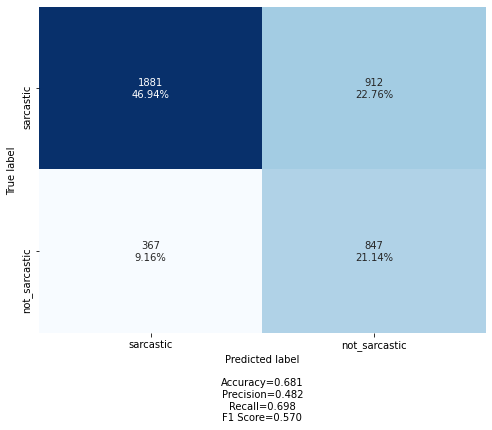

time: 4.59 s (started: 2021-08-08 20:29:44 +00:00)


In [22]:
y_pred = opt_df.predict(test_x)
cf_matrix = confusion_matrix(y_pred, test_y)
labels = ['sarcastic','not_sarcastic']
cf_matrix
make_confusion_matrix(cf_matrix,categories=labels, figsize=(8,6), cbar=False)

In [23]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

probs = opt_df.predict_proba(test_x)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, probs[:,i], pos_label=i)
    
random_probs = [0 for i in range(len(test_y))]
p_fpr, p_tpr, _ = roc_curve(test_y, random_probs, pos_label=1)

time: 4.58 s (started: 2021-08-08 20:29:49 +00:00)


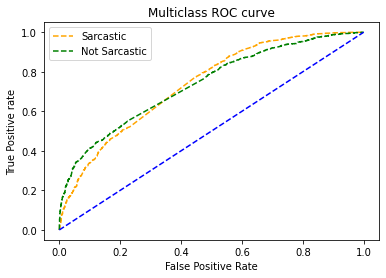

time: 245 ms (started: 2021-08-08 20:29:53 +00:00)


In [24]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Sarcastic')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Not Sarcastic')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=300)